# Assignment notebook

### Load modules

In [5]:
# os
import os

# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

### Load Data 

In [18]:
# > Prepate data
def prep_data():
    # Print info
    print("[INFO] loading data...")
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    # Normalize data 
    X_train = X_train/255
    X_test = X_test/255
    # Create one-hot encodings (Still not sure what this does)
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    y_test = lb.fit_transform(y_test)
    # Initialize label names
    label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    # Print info
    print("[INFO] Data loaded")
    
    return (X_train, y_train), (X_test, y_test), label_names

In [7]:
(X_train, y_train), (X_test, y_test), label_names = prep_data()

In [8]:
type(X_train)

numpy.ndarray

### Feature extraction

In [16]:
# To keep me from adding to the model when I do not want to 
tf.keras.backend.clear_session() # Not sure if this smar to have in the final product?

In [11]:
# Initialize model 
model = VGG16(include_top = False, # Do not include classifier!
              pooling = "avg", # Pooling the final layer  
              input_shape = (32, 32, 3)) # Defineing input shape

In [12]:
# Disable training on convolutional layers
for layer in model.layers:
    layer.trainable = False

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Add classification layers__

In [14]:
# Add layers 
# The second pair of closed brackets is the input 
flat1 = Flatten()(model.layers[-1].output) # create a flatten layer from the output for the last layer of the model
class1 = Dense(128, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)

# Adding everything together
model = Model(inputs = model.inputs, 
              outputs = output)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Compiling__

In [19]:
# Slowing down the model's learning to avoid overfitting
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9)

sgd = SGD(learning_rate=lr_schedule)

In [20]:
model.compile(optimizer=sgd,
             loss="categorical_crossentropy", # binary_crossentropy for binary categories 
             metrics=["accuracy"])

### Testing function

In [20]:
def create_model():
    # Print info 
    print("[INFO] Initializing model")
    
    # > Initialize model 
    model = VGG16(include_top = False, # Do not include classifier!
                  pooling = "avg", # Pooling the final layer  
                  input_shape = (32, 32, 3)) # Defineing input shape
    # Disable training on convolutional layers
    for layer in model.layers:
        layer.trainable = False
        
    # > Add layers 
    # The second pair of closed brackets is the input 
    flat1 = Flatten()(model.layers[-1].output) # create a flatten layer from the output for the last layer of the model
    class1 = Dense(128, activation='relu')(flat1)
    output = Dense(10, activation='softmax')(class1)
    # Adding everything together
    model = Model(inputs = model.inputs, 
                  outputs = output)
    
    # Print info
    print("[INFO] Compiling model")
    # Slowing down the model's learning to avoid overfitting
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=1000,
        decay_rate=0.9)

    sgd = SGD(learning_rate=lr_schedule)
    # Compiling model
    model.compile(optimizer=sgd,
             loss="categorical_crossentropy", # binary_crossentropy for binary categories 
             metrics=["accuracy"])
    # Print info
    print("[INFO] Model compiled!")
    print("[INFO] Model summary:")
    model.summary()
    
    return model
    

In [21]:
model = create_model()

[INFO] Initializing model
[INFO] Compiling model
[INFO] Model compiled!
[INFO] Model summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                 

__Train__

In [22]:
H = model.fit(X_train, y_train,
             validation_data = (X_test, y_test), # Was there a way to split up the validation data further?
             batch_size = 128, # two to the power of something to optimize memory
             epochs = 10, # Should I change this later? Perhaps make an argument that allows the user to specify so I don't have to think about it?
             verbose = 1) # Tell me wht is happening 

Epoch 1/10
391/391 [==============================] - 48s 123ms/step - loss: 2.0342 - accuracy: 0.2989 - val_loss: 1.8419 - val_accuracy: 0.3836
Epoch 2/10
391/391 [==============================] - 47s 120ms/step - loss: 1.7286 - accuracy: 0.4213 - val_loss: 1.6633 - val_accuracy: 0.4304
Epoch 3/10
391/391 [==============================] - 47s 120ms/step - loss: 1.5973 - accuracy: 0.4568 - val_loss: 1.5698 - val_accuracy: 0.4581
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 1.5244 - accuracy: 0.4784 - val_loss: 1.5142 - val_accuracy: 0.4778
Epoch 5/10
391/391 [==============================] - 47s 120ms/step - loss: 1.4780 - accuracy: 0.4921 - val_loss: 1.4817 - val_accuracy: 0.4894
Epoch 6/10
391/391 [==============================] - 47s 120ms/step - loss: 1.4445 - accuracy: 0.5030 - val_loss: 1.4520 - val_accuracy: 0.4980
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 1.4193 - accuracy: 0.5106 - val_loss: 1.4305 - val_ac

### Report results

In [36]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    # Saving image
    plt.savefig(os.path.join("..", "output", "history_img.png"))
    plt.show()

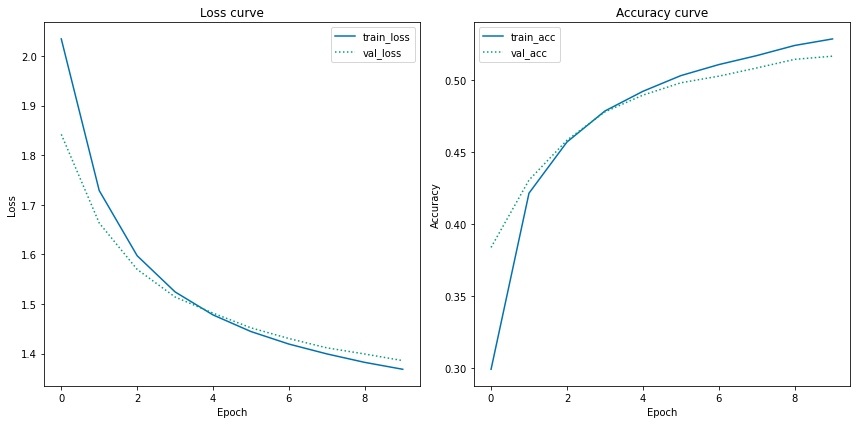

In [35]:
plot_history(H, 10)

In [25]:
predictions = model.predict(X_test, batch_size = 128)
print(classification_report(y_test.argmax(axis=1), # argmax = find the prediction with the highest value
                           predictions.argmax(axis=1),
                           target_names=label_names))

              precision    recall  f1-score   support

    airplane       0.56      0.59      0.58      1000
  automobile       0.56      0.56      0.56      1000
        bird       0.43      0.35      0.39      1000
         cat       0.38      0.36      0.37      1000
        deer       0.48      0.54      0.51      1000
         dog       0.52      0.43      0.47      1000
        frog       0.53      0.63      0.57      1000
       horse       0.58      0.53      0.55      1000
        ship       0.59      0.65      0.62      1000
       truck       0.50      0.53      0.52      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000



### Testing functions